### Introduction
The Boston Housing Study dataset has 506 observations and 13 columns. The response variable is the median value of homes in several neighborhoods. Neighborhood category variable was dropped when we prepared data for regression analysis.  We need to use various regression models to determine the overall performance in terms of root-mean-squared error and recommend the best performer to management.

In [1]:
# seed value for random number generators to obtain reproducible results
RANDOM_SEED = 1

# ignore all future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# Execute the code line by line in jupyter-notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# import base packages into the namespace for this program
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# modeling routines from Scikit Learn packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt  # for root mean-squared error calculation

In [2]:
# read data for the Boston Housing Study
boston_input = pd.read_csv('boston.csv')

In [3]:
# drop neighborhood from the data being considered
# response variable is house median value
boston = boston_input.drop('neighborhood', 1)

### Skipping the data exploration and visualization

The data is clean and there are no null values.

### Data Preparation for Modeling

In [4]:
# the mv column is the response variable
# the remaining columns are the explanatory variables

## boston.values # convert to array
y = boston[['mv']].values.ravel()
X = boston.loc[:, 'crim':'lstat'].values

In [5]:
# here we split our data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = RANDOM_SEED)
print("X.shape:", X.shape, "     X_train.shape:", X_train.shape, "     X_test.shape:", X_test.shape)

X.shape: (506, 12)      X_train.shape: (404, 12)      X_test.shape: (102, 12)


### Model Exploration

In [6]:
def performance_score (model, model_name):
    # performance score calculation
    train_score = np.round(model.score(X_train, y_train),3) # R-square
    test_score = np.round(model.score(X_test, y_test),3) # R-square
    train_RMSE = np.round(np.sqrt(mean_squared_error(y_train, model.predict(X_train))),3)
    test_RMSE = np.round(np.sqrt(mean_squared_error(y_test, model.predict(X_test))),3)

    # performance score table
    col_names = ['Regression','Training RMSE', 'Test RMSE', 'Training Score', 'Test Score']
    perf = pd.DataFrame([model_name, train_RMSE, test_RMSE, train_score, test_score], columns = [''],
                            index = col_names).T
    return perf

**Linear Models: Lasso**

In [7]:
lasso10 = Lasso(alpha = 10).fit(X_train, y_train)
lasso10_p = performance_score(lasso10, 'lasso10'); lasso10_p
print("Number of features used:", np.sum(lasso10.coef_ != 0))

,Regression,Training RMSE,Test RMSE,Training Score,Test Score
,lasso10,6.117,7.164,0.535,0.481


Number of features used: 3


Lasso does quite badly, both on the training and the test set. This indicates that we are underfitting, and we find that it used only 3 of the 12 features. Lasso has a regularization parameter, alpha, that controls how strongly coefficients are pushed toward zero. The default alpha is 1.0.

In [8]:
lasso01 = Lasso(alpha = 0.01).fit(X_train, y_train)
lasso01_p = performance_score(lasso01, 'lasso01'); lasso01_p
print("Number of features used:", np.sum(lasso01.coef_ != 0))

,Regression,Training RMSE,Test RMSE,Training Score,Test Score
,lasso01,4.662,4.948,0.73,0.752


Number of features used: 12


A lower alpha allowed us to fit a more complex model, which worked better on the training and test data. Using alpha=0.01, we get a model that is quite unregularized, with most coefficients nonzero and of large magnitude. We are using all 12 features. We have around 400 training data. However, with enough training data, regularization becomes less important.

**Linear Models: Linear Regression**

In [9]:
lr = LinearRegression().fit(X_train, y_train)
lr_p = performance_score(lr, 'Linear Regression'); lr_p

,Regression,Training RMSE,Test RMSE,Training Score,Test Score
,Linear Regression,4.658,4.951,0.73,0.752


Linear model results are similar to the lasso01. 

**Decision Trees: Random Forrest**

Ensembles are methods that combine multiple decision tree models to create more powerful models: random forests and gradient boosted decision trees. <br>
As each feature is processed separately, and the possible splits of the data don’t depend on scaling, no preprocessing like normalization or standardization of features is needed for decision tree algorithms. In particular, decision trees work well when you have features that are on completely different scales, or a mix of binary and continuous features.

In [10]:
def plot_feature_importances(model):
    y = boston[['mv']]
    X = boston.loc[:, 'crim':'lstat']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = RANDOM_SEED)
    n_features = X_train.shape[1]
    plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X_train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features);

,Regression,Training RMSE,Test RMSE,Training Score,Test Score
,Random Forest,1.265,3.142,0.98,0.9


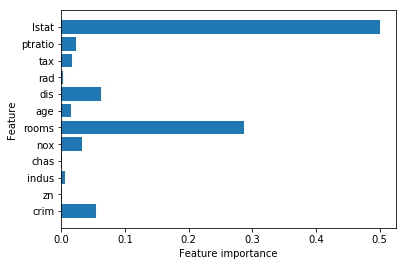

In [11]:
forest = RandomForestRegressor(random_state = RANDOM_SEED).fit(X_train, y_train)

forest_p = performance_score(forest, 'Random Forest'); forest_p
plot_feature_importances(forest)

Default values: 
* We repeatedly draw a sample randomly with replacement (meaning the same sample can be picked multiple times) or bootstrap = True 
* The number of trees in the forest or n_estimators = 10

The random forest gives us a lower RMSE of 3.142 and higher R-square score of 90%, better than the linear models without tuning any parameters.

According to the  Random Forest features importance model, the poverty rate (lstat), rooms per house (rooms), commute to work (dis), and crime rate (crim) features are important to predict the median value of homes.

In [12]:
forest500 = RandomForestRegressor(n_estimators = 500,
                                  random_state = RANDOM_SEED).fit(X_train, y_train)

forest500_p = performance_score(forest500, 'Random Forest 500'); forest500_p
##plot_feature_importances(forest500)

,Regression,Training RMSE,Test RMSE,Training Score,Test Score
,Random Forest 500,1.122,2.968,0.984,0.911


When I increased the number of trees from the default ten trees to 500 trees, the model gave slightly better results. There is no change in feature importance.

**Decision Trees: Gradient Boosted** <br>
Each tree tries to correct the mistakes of the previous one. By default, there is no randomization in gradient boosted regression trees; instead, strong pre-pruning is used

,Regression,Training RMSE,Test RMSE,Training Score,Test Score
,Gradient Boosting,1.359,2.584,0.977,0.932


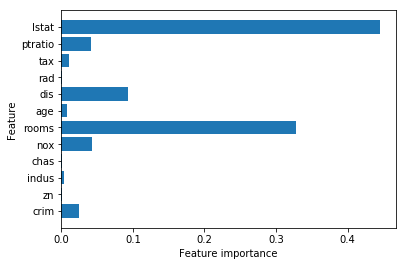

In [13]:
GB = GradientBoostingRegressor(random_state = RANDOM_SEED).fit(X_train, y_train)
GB_p = performance_score(GB, 'Gradient Boosting'); GB_p
plot_feature_importances(GB)

Gradient Boosting gave us much better results. However, tuning the learning rate and max depth parameters did not make any improvements. <br>
We can see that the feature importances of the gradient boosted trees are somewhat similar to the feature importances of the random forests, though the gradient boosting completely ignored some of the features. According to the  Gradient Boosting features importance model, the poverty rate (lstat), rooms per house (rooms), commute to work (dis), pupil/teacher ratio (ptratio), and air pollution (nox) features are important to predict the median value of homes.

In [14]:
GB500 = GradientBoostingRegressor(n_estimators = 500,
                               random_state = RANDOM_SEED).fit(X_train, y_train)
GB500_p = performance_score(GB500, 'Gradient Boosting 500'); GB500_p
##plot_feature_importances(GB500)

,Regression,Training RMSE,Test RMSE,Training Score,Test Score
,Gradient Boosting 500,0.291,2.483,0.999,0.938


Adding more trees to the ensemble, which can be accomplished by increasing n_estimators, also increases the model complexity, as the model has more chances to correct mistakes on the training set.There is no change in feature importance. Even though the model gave slightly better results, the training set scores improved more than the testing ones which indicates there is less regularization and higher chance of overfitting. As the training score is almost 100%, the model is likely to be overfitting. To reduce overfitting, we could either apply stronger pre-pruning by limiting the maximum depth or lower the learning rate. However, those parameters also reduce the testing scores. 

**Summary**

In [15]:
pd.concat([lasso10_p, lasso01_p, lr_p, forest_p, 
           forest500_p, GB_p, GB500_p], axis = 0)

,Regression,Training RMSE,Test RMSE,Training Score,Test Score
,lasso10,6.117,7.164,0.535,0.481
,lasso01,4.662,4.948,0.73,0.752
,Linear Regression,4.658,4.951,0.73,0.752
,Random Forest,1.265,3.142,0.98,0.9
,Random Forest 500,1.122,2.968,0.984,0.911
,Gradient Boosting,1.359,2.584,0.977,0.932
,Gradient Boosting 500,0.291,2.483,0.999,0.938


This exercise builds on the linear regression models we developed for assignment 3 and uses the same data set. We drop the variable 'neighborhood' and use the remaining continuous data variables to build multiple models using SciKit Learn: Linear Regression, Lasso, RandomForestRegressor, & GradientBoostingRegressor with various parameters. By experimenting with bootstrapping, we are able to build models that perform well on both training and testing datasets, better than the regression models in assignment 3. We were able to minimize the errors (RMSE) and increased the score (R-square). I recommend management the best performer model to predict the median value of homes is gradient booster. 